Ignacio Vellido Expósito

In [ ]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

In [ ]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
       Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

In [ ]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
 
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
                
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
 
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
 
                loss = (y[i] - F).flatten() ** 2
                # print('Epoch: {0} - Loss: {1:.2f}'.format(epoch,loss[0]))
 
                # backward pass
                error = -(y[i] - F).flatten()
 
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
            
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise
 
# parameters
lr     = 1e-2
k      = 2
epochs = 100
infer  = True

rbfnet = RBFNet(lr=lr, k=k, epochs=epochs, inferStds=infer)
rbfnet.fit(X, y)

# ------------------------------------------------------------------------------

# Get predictions
y_pred = rbfnet.predict(X)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MSE: {}".format(mean_squared_error(y, y_pred)))
print("MAE: {}".format(mean_absolute_error(y, y_pred)))
print("R2:  {}".format(r2_score(y, y_pred)))

MSE: 0.029813470213071874
MAE: 0.14802081047032367
R2:  0.9426267343023126


### Podemos intentar jugar con algunos parámetros clave, como el número de bases. ¿Qué pasa si aumentamos el número de bases a 4? ¿Es mejor el resultado? ¿Qué está ocurriendo?

Con 4 bases el ajuste empeora fuertemente. Esto se debe a que la función seno se puede aproximar perfectamente con dos gaussianas (y obtendríamos un ajuste perfecto si no se introdujera ruido), pero al forzarle al RBF a incluir dos gaussianas más el ajuste se vuelve difícil al tener que aprender a minimizar los efectos de las nuevas curvas.

---

### Otro parámetro que podemos cambiar es la desviación estándar. ¿Qué tal si usamos una única desviación estándar para todas nuestras bases en lugar de que cada una tenga su propia?

Al provenir los datos de una función seno entre cero y uno (si no existiera ruido) los resultados deberían ser exactamente iguales que cuando inferimos las desviaciones desde KMeans. La obtención de una calidad un tanto menor probablemente se deba al ruido introducido, que vuelva útil la inferencia.

Desde un punto de vista global, el uso de una única desviación limita la función que es capaz de modelar la red. Esto puede ser por un lado bueno, ya que ayuda a regularizar y evitar el sobreajuste, dónde por ejemplo podría ser útil en la predicción de series temporales periódicas.

En general, si compartimos la desviación no contamos con la información aportada por KMeans, pero reduce el efecto de este algoritmo (y por tanto la selección de centroides iniciales).

---

### Lanzad varias ejecuciones con diferentes parámetros buscando la mejor configuración para la Red Neuronal RBF. Recogedlos en una tabla y sacad conclusiones

Hacemos notar la variabilidad de las métricas bajo la influencia del número de épocas. En base a los resultados parece verse que si KMeans devuelve muy buenos centroides podemos alcanzar sobreaprendizaje rápidamente.

En general la arquitectura se ve muy dependiente de estos centroides iniciales, pues solo entrena los pesos de cada gaussiana.

Como se ha comentado anteriormente, puesto que las RBF son aproximadores universales, se destaca la importancia de elegir bien el número de bases a utilizar.

lr = 1e-2 --
k  = 2 --
epoch = 100 --
infer = T

MSE: 0.012993250821024762 --
MAE: 0.09150720740716947 --
R2:  0.9726513753688459

---
lr = 1e-2 --
k  = 4 --
epoch = 100 --
infer = T

MSE: 0.012993250821024762 --
MAE: 0.09150720740716947 --
R2:  0.9726513753688459

---
lr = 1e-3 --
k  = 4 --
epoch = 300 --
infer = T

MSE: 0.08709622598653041 --
MAE: 0.23480053228685255 --
R2:  0.8064617007227907

---
lr = 1e-2 --
k  = 2 --
epoch = 100 --
infer = F

MSE: 0.051636025999160534 --
MAE: 0.18360628475807364 --
R2:  0.8995517155495046

---
lr     = 1e-2 --
k      = 2 --
epochs = 200 --
infer  = F

MSE: 0.04099425906905418 --
MAE: 0.15793398384634696 --
R2:  0.9207490991482732

---
lr     = 1e-2 --
k      = 2 --
epochs = 80 --
infer  = T

MSE: 0.007586599963284586 --
MAE: 0.07121299226572969 --
R2:  0.9854609012031087

---
lr     = 1e-2 --
k      = 2 --
epochs = 6 --
infer  = T

MSE: 0.055137935294415234 --
MAE: 0.20291586043737722 --
R2:  0.9007798073744795

---
lr     = 1e-2 --
k      = 2 --
epochs = 6 --
infer  = T

MSE: 0.1294900343669023 --
MAE: 0.2942483241167328 --
R2:  0.7199315038559271

---

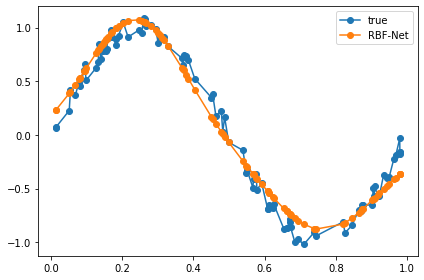

In [ ]:
# 2 bases
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

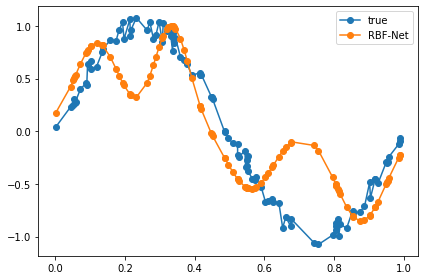

In [ ]:
# 4 bases
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

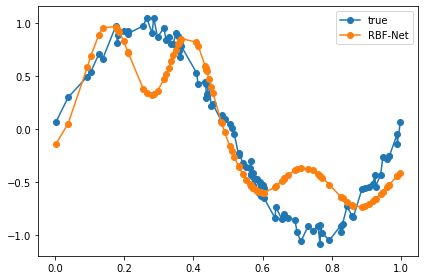

In [ ]:
# 4 bases, 300 epochs, 1e-3 lr
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

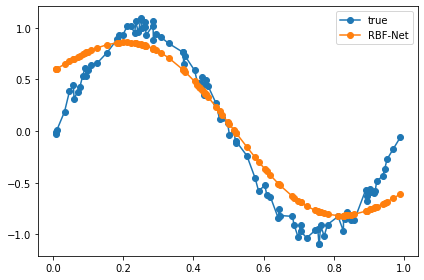

In [ ]:
# 2 bases, infer=T
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

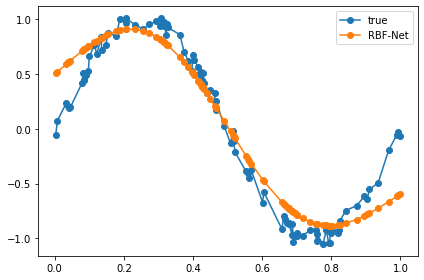

In [ ]:
# 2 bases, infer=T, epochs=200
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

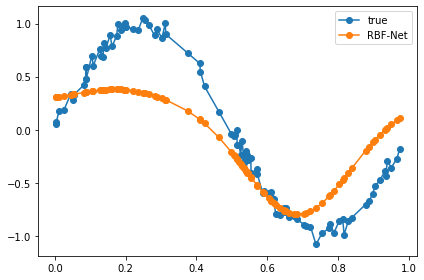

In [ ]:
# 2 bases, epochs=6
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()